In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random as rnd

import matplotlib.pyplot as plt

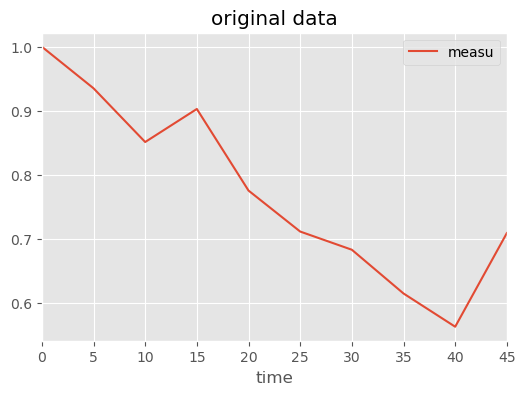

In [14]:
time_int = 5
time_unit = 'weeks'
measu=np.array([1.0000,0.9351,0.8512,0.9028,0.7754,0.7114,0.6830,0.6147,0.5628,0.7090]).reshape((-1,1))

time = np.zeros((len(measu),1))
time[0,:] = 0
for i in range (1,len(measu)):
    time[i,:] = time[i-1,:]+time_int

data=pd.DataFrame(data=np.column_stack((time,measu)),columns=['time','measu'])
data.plot(x='time',y='measu',figsize=(6,4),title="original data").autoscale(axis='x',tight=True);

In [15]:
# model parameter
# probability parameters of initial distribution, p x q
# p: num. of unknown param
# q: num. of probability pa
rnd.seed(1)
ParamNumber = 3
ParamIn = pd.DataFrame({'paramname': ["x", "b", "s"],
                   'lowerlimit': [0.9,0,0.01],
                   'upperlimit': [1.1,0.05,0.1]})

# number of particle
numparticle = 1000
# significance level for C.I. and P.I.
signiLevel = 5  

thres=0.3

In [16]:
# initialize particle for the Params
xresul = np.random.uniform(ParamIn['lowerlimit'].iloc[0],ParamIn['upperlimit'].iloc[0],numparticle)
bresul = np.random.uniform(ParamIn['lowerlimit'].iloc[1],ParamIn['upperlimit'].iloc[1],numparticle)
sresul = np.random.uniform(ParamIn['lowerlimit'].iloc[2],ParamIn['upperlimit'].iloc[2],numparticle)

# reshape
xresul = np.resize (xresul,(1,len(xresul)))
bresul = np.resize (bresul,(1,len(bresul)))
sresul = np.resize (sresul,(1,len(sresul)))

param = np.concatenate((xresul,bresul,sresul), axis=0)

# index where prognosis starts
k1 = len(measu)-1; 
# Update Process or Prognosis
k=0;               

if measu[-1] - measu[0]<0:
    cofec=-1; 
else: 
    cofec=1; 

""" MAIN PF """ 
while (min(xresul[k,:]*cofec))<(thres*cofec):
    k = k+1
    # step 1. prediction (prior)
    parampredi = param
    
    x = parampredi[0,:]
    b = parampredi[1,:]
    s = parampredi[2,:]
    
    # reshape
    x = np.resize (x,(1,len(x)))
    b = np.resize (b,(1,len(b)))
    s = np.resize (s,(1,len(s)))

    # model Prior
    parampredi[0,:] = np.exp(-1*b*time_int)*x
    
    if k<=k1:
        # step 2. update (likelihood)
        # return the pdf of the normal distribution with 
        # mean x and standard deviation s, evaluated at the values in actual state.
        likel = norm.pdf(measu[k], parampredi[0,:], parampredi[2,:]);
        likel = np.resize (likel,(1,len(likel)))
        
        # step 3. resampling
        cdf = np.cumsum(likel)/np.sum(likel)
        cdf = np.resize (cdf,(1,len(cdf)))
        
        for i in range (0, numparticle):
            u = rnd.random()
            loca = np.where(cdf[0,:]>=u)
            loca = np.transpose(np.asarray(loca))
            param [:,i] = np.transpose(parampredi[:,loca[0]])
        
        tempx = param[0,:]
        tempx = np.resize (tempx,(1,len(tempx)))
        xresul = np.concatenate((xresul,tempx), axis=0)

        tempb = param[1,:]
        tempb = np.resize (tempb,(1,len(tempb)))
        bresul = np.concatenate((bresul,tempb), axis=0)
    
        temps = param[2,:]
        temps = np.resize (temps,(1,len(temps)))
        sresul = np.concatenate((sresul,temps), axis=0)
    else: # prognosis
        param = parampredi
    

    # prediction future state, sample from normal distribution
    if k>k1:
        tempx = np.random.normal(param[0,:],param[2,:])
        tempx = np.resize (tempx,(1,len(tempx)))
        xresul = np.concatenate((xresul,tempx), axis=0)
        

In [17]:
# %%
""" Post-Processing """
time_p = np.zeros((k,1))
time_p[0,:] = 0
for i in range (1,k):
    time_p[i,:] = time_p[i-1,:]+time_int

perceValue = [50, signiLevel, 100-signiLevel]

RUL = np.zeros((1,numparticle)) 

for i in range (0,numparticle):
    loca2 = np.where((xresul[:,i]*cofec)>=(thres*cofec))
    loca2 = np.transpose(np.asarray(loca2))
    RUL[0,i] = time_p[loca2[0]]-time_p[k1]
    
# calculate the pecentile from RUL
RULPerce = np.percentile(RUL[0,:],perceValue)

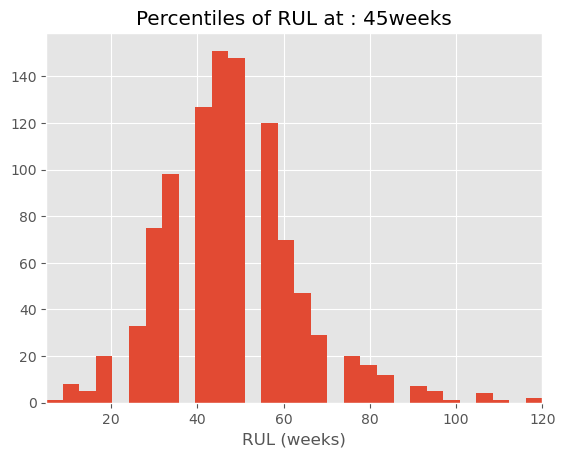

In [18]:
plt.style.use("ggplot")
plt.hist(RUL[0,:], bins = 30)
plt.xlabel('RUL ('+time_unit+')')
plt.xlim(np.min(RUL),np.max(RUL))
title = 'Percentiles of RUL at : ' + str(int(time_p.ravel()[k1])) + time_unit
plt.title(title)
plt.show()

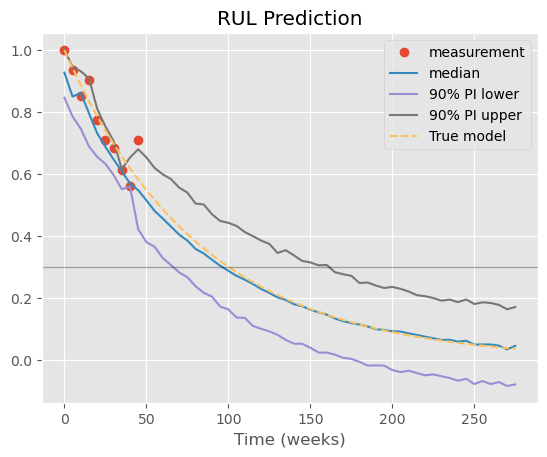

In [19]:
# calculate percentile at each time step
xresulPerce = np.percentile(xresul,perceValue,axis=1)
plt.style.use("ggplot")
plt.plot(time_p[0:len(measu)],data['measu'].iloc[:],'o', label="measurement")
plt.plot(time_p,xresulPerce[0][1:],label = "median")
plt.plot(time_p,xresulPerce[1][1:],label = "90% PI lower")
plt.plot(time_p,xresulPerce[2][1:],label = "90% PI upper")
plt.plot(time_p, np.exp(-0.012*time_p),'--', label = "True model")
plt.axhline(0.3,linewidth=1, color="black",alpha=0.3)
plt.xlabel('Time ('+time_unit+')')
plt.title('RUL Prediction')
plt.legend()
plt.show()